# Cerebrum Artis: Comprehensive System Demo (V3.1 Integrated)

Este notebook demonstra o funcionamento completo do sistema **Cerebrum Artis V3.1 (Integrated Fuzzy-Neural Gating)**.

**Funcionalidades demonstradas:**
1.  **Entrada Flexível**: Aceita Imagem + Legenda (Opcional). Se a legenda não for fornecida, o módulo **SAT (Show, Attend and Tell)** gera uma automaticamente.
2.  **Análise Multimodal**: Processa visual (ResNet50), textual (RoBERTa) e features artísticas (Fuzzy).
3.  **Transparência do Modelo**:
    *   Visualização das probabilidades da branch **Neural**.
    *   Visualização das probabilidades da branch **Fuzzy**.
    *   Cálculo do **Agreement** (Concordância) que regula o Gating Mechanism.
4.  **Explicabilidade (XAI)**:
    *   **Grad-CAM**: Mapa de calor mostrando onde o modelo "olhou".
    *   **Análise Textual**: Explicação do porquê da decisão.

---

In [6]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from transformers import RobertaTokenizer, RobertaModel
from torchvision import models, transforms
from scipy.ndimage import zoom  # Para interpolação do Grad-CAM
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Configuração de caminhos
PROJECT_ROOT = Path('/home/paloma/cerebrum-artis')
sys.path.insert(0, str(PROJECT_ROOT))
# Adiciona o caminho do fuzzy_brain
sys.path.insert(0, str(PROJECT_ROOT / 'cerebrum_artis/fuzzy'))

# Importa o FuzzyInferenceSystem
from fuzzy_brain.fuzzy.system import FuzzyInferenceSystem

# Importa o extrator VISUAL CORRETO (HSV-based)
from fuzzy_brain.extractors.visual import VisualFeatureExtractor

# Importa SAT Loader SIMPLIFICADO
from fuzzy_brain.sat_loader_simple import SATModelLoader

# Configuração de visualização
plt.style.use('seaborn-v0_8-paper')
sns.set_context("notebook", font_scale=1.2)

# Device (GPU 2 que está livre)
device = torch.device('cuda:2')
print(f"🚀 Running on {device}")

# Emoções ArtEmis
EMOTIONS = [
    'amusement', 'awe', 'contentment', 'excitement', 
    'anger', 'disgust', 'fear', 'sadness', 'something else'
]

print("✅ Imports concluídos com sucesso!")

🚀 Running on cuda:2
✅ Imports concluídos com sucesso!


In [7]:
# ============================================================================
# 1. DEFINIÇÃO DO MODELO V3.1 (Integrated Fuzzy-Neural Gating)
# ============================================================================
# Copiado de cerebrum_artis/models/v3_1_integrated/train_v3_1.py para garantir execução standalone

class IntegratedFuzzyGatingClassifier(nn.Module):
    def __init__(self, num_classes=9, freeze_resnet=True, dropout=0.3,
                 base_alpha=0.5, min_alpha=0.2, max_alpha=0.8):
        super().__init__()
        
        self.num_classes = num_classes
        self.base_alpha = base_alpha
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        
        # Vision: ResNet50
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        
        # Text: RoBERTa
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        
        # Neural classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        # 🔥 INTEGRATED: Fuzzy system as model component
        self.fuzzy_system = FuzzyInferenceSystem()
        self.emotion_names = EMOTIONS
    
    def _batch_fuzzy_inference(self, fuzzy_features_batch):
        batch_size = fuzzy_features_batch.size(0)
        device = fuzzy_features_batch.device
        fuzzy_probs_list = []
        
        for i in range(batch_size):
            features_dict = {
                'brightness': fuzzy_features_batch[i, 0].item(),
                'color_temperature': fuzzy_features_batch[i, 1].item(),
                'saturation': fuzzy_features_batch[i, 2].item(),
                'color_harmony': fuzzy_features_batch[i, 3].item(),
                'complexity': fuzzy_features_batch[i, 4].item(),
                'symmetry': fuzzy_features_batch[i, 5].item(),
                'texture_roughness': fuzzy_features_batch[i, 6].item()
            }
            fuzzy_dist = self.fuzzy_system.infer(features_dict)
            fuzzy_prob = torch.tensor(
                [fuzzy_dist.get(e, 0.0) for e in self.emotion_names],
                device=device, dtype=torch.float32
            )
            fuzzy_probs_list.append(fuzzy_prob)
        
        return torch.stack(fuzzy_probs_list)
    
    def _adaptive_fusion(self, neural_logits, fuzzy_probs):
        neural_probs = torch.softmax(neural_logits, dim=1)
        agreement = torch.nn.functional.cosine_similarity(neural_probs, fuzzy_probs, dim=1)
        agreement = (agreement + 1) / 2
        adaptive_alpha = self.max_alpha - (self.max_alpha - self.min_alpha) * agreement
        adaptive_alpha = adaptive_alpha.unsqueeze(1)
        final_probs = adaptive_alpha * neural_probs + (1 - adaptive_alpha) * fuzzy_probs
        final_logits = torch.log(final_probs + 1e-8)
        return final_logits, agreement, adaptive_alpha.squeeze(1), neural_probs
    
    def forward(self, image, input_ids, attention_mask, fuzzy_features=None, return_components=False):
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_output.last_hidden_state[:, 0, :]
        
        combined = torch.cat([visual_feats, text_feats], dim=1)
        neural_logits = self.classifier(combined)
        
        if fuzzy_features is None:
            if return_components: return neural_logits, None, None, neural_logits, None
            return neural_logits
        
        fuzzy_probs = self._batch_fuzzy_inference(fuzzy_features)
        final_logits, agreement, alpha, neural_probs = self._adaptive_fusion(neural_logits, fuzzy_probs)
        
        if return_components:
            return final_logits, agreement, alpha, neural_probs, fuzzy_probs
        return final_logits

In [8]:
# ============================================================================
# 2. CARREGAMENTO DOS MODELOS (SAT + V3.1)
# ============================================================================

def load_sat_model():
    """Carrega o modelo SAT (Show, Attend and Tell) REAL para gerar legendas."""
    print("📝 Carregando modelo SAT...")
    
    # Caminhos dos checkpoints SAT
    sat_checkpoint = PROJECT_ROOT / 'cerebrum_artis/models/checkpoints/sat_best_model.pt'
    sat_vocab = PROJECT_ROOT / 'data/artemis/dataset/full_combined/train/vocabulary.pkl'
    
    if not sat_checkpoint.exists():
        print(f"❌ SAT checkpoint não encontrado em {sat_checkpoint}")
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None
    
    if not sat_vocab.exists():
        print(f"❌ SAT vocabulário não encontrado em {sat_vocab}")
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None
    
    try:
        sat = SATModelLoader(
            checkpoint_path=str(sat_checkpoint),
            vocab_path=str(sat_vocab),
            use_emotion_labels=True,
            device=str(device)
        )
        print(f"✅ SAT carregado: {len(sat.vocab)} tokens no vocabulário")
        return sat
    except Exception as e:
        print(f"❌ Erro ao carregar SAT: {e}")
        import traceback
        traceback.print_exc()
        print("⚠️ Usando modo CAPTION MANUAL (sem geração automática)")
        return None

def load_v3_model():
    """Carrega o modelo V3.1 Integrated TREINADO."""
    print("🧠 Carregando Cerebrum Artis V3.1...")
    model = IntegratedFuzzyGatingClassifier(num_classes=9)
    
    # CAMINHO CORRETO do checkpoint V3.1 treinado
    checkpoint_path = Path('/data/paloma/deep-mind-checkpoints/v3_1_integrated/checkpoint_best.pt')
    
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint.get('epoch', 'N/A')
        val_acc = checkpoint.get('val_acc', 'N/A')
        print(f"✅ Checkpoint carregado: epoch {epoch}, val_acc={val_acc:.4f}")
    else:
        raise FileNotFoundError(f"Checkpoint não encontrado em {checkpoint_path}")
    
    model.to(device)
    model.eval()
    
    # DEBUGGING: Mostra estrutura do visual_encoder
    print("\n🔍 Estrutura do visual_encoder:")
    for i, layer in enumerate(model.visual_encoder):
        print(f"   [{i}]: {type(layer).__name__}")
        if i == 7:  # layer4
            print(f"        ↳ Contém {len(layer)} Bottlenecks")
    print(f"   ✅ Target layer para Grad-CAM: visual_encoder[7][-1] (último Bottleneck)")
    
    return model

# Inicialização
sat_model = load_sat_model()
v3_model = load_v3_model()
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
visual_extractor = VisualFeatureExtractor()  # Extrator HSV CORRETO

print("\n✅ Sistema Inicializado Completo!")

📝 Carregando modelo SAT...
📚 Carregando vocabulário...
  ✅ Vocabulário: 17440 tokens
🧠 Construindo modelo SAT...


/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚙️  Carregando checkpoint...
  ✅ SAT carregado! (epoch 7)
✅ SAT carregado: 17440 tokens no vocabulário
🧠 Carregando Cerebrum Artis V3.1...
  ✅ SAT carregado! (epoch 7)
✅ SAT carregado: 17440 tokens no vocabulário
🧠 Carregando Cerebrum Artis V3.1...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

✅ Sistema Fuzzy inicializado com 18 regras
✅ Checkpoint carregado: epoch 6, val_acc=70.3986

🔍 Estrutura do visual_encoder:
   [0]: Conv2d
   [1]: BatchNorm2d
   [2]: ReLU
   [3]: MaxPool2d
   [4]: Sequential
   [5]: Sequential
   [6]: Sequential
   [7]: Sequential
        ↳ Contém 3 Bottlenecks
   [8]: AdaptiveAvgPool2d
   ✅ Target layer para Grad-CAM: visual_encoder[7][-1] (último Bottleneck)
✅ Checkpoint carregado: epoch 6, val_acc=70.3986

🔍 Estrutura do visual_encoder:
   [0]: Conv2d
   [1]: BatchNorm2d
   [2]: ReLU
   [3]: MaxPool2d
   [4]: Sequential
   [5]: Sequential
   [6]: Sequential
   [7]: Sequential
        ↳ Contém 3 Bottlenecks
   [8]: AdaptiveAvgPool2d
   ✅ Target layer para Grad-CAM: visual_encoder[7][-1] (último Bottleneck)

✅ Sistema Inicializado Completo!

✅ Sistema Inicializado Completo!


In [9]:
# ============================================================================
# 3. FUNÇÕES AUXILIARES E PIPELINE
# ============================================================================

def process_image(image_path):
    """Carrega e processa imagem para o modelo."""
    image = Image.open(image_path).convert('RGB')
    
    # Transform para ResNet
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return image, transform(image).unsqueeze(0).to(device)

def process_text(text):
    """Tokeniza o texto para RoBERTa."""
    tokens = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens['input_ids'].to(device), tokens['attention_mask'].to(device)

def generate_caption_with_sat(image_path):
    """Gera legenda usando SAT (se disponível)."""
    if sat_model is None:
        return None
    
    try:
        # Carrega imagem
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        
        # SAT espera imagem como array numpy RGB
        caption = sat_model.generate_caption(
            img_array,
            max_len=20,
            temperature=1.0,
            emotion=None  # Sem emoção pré-definida
        )
        return caption
    except Exception as e:
        print(f"⚠️ Erro na geração SAT: {e}")
        return None

def compute_gradcam_corrected(model, image_tensor, target_class, input_ids, attention_mask, fuzzy_tensor):
    """
    Compute Grad-CAM CORRIGIDO para V3.1 model
    
    CORREÇÕES CRÍTICAS:
    1. DESCONGELA temporariamente a ResNet para permitir gradientes
    2. Usa layer CORRETA: visual_encoder[7][-1] (último Bottleneck)
    3. Normaliza CAM adequadamente
    """
    
    # 🔥 CRÍTICO: Descongela ResNet TEMPORARIAMENTE
    was_frozen = not next(model.visual_encoder.parameters()).requires_grad
    if was_frozen:
        print("   🔓 Descongelando ResNet temporariamente para Grad-CAM...")
        for param in model.visual_encoder.parameters():
            param.requires_grad = True
    
    model.eval()
    
    # Hooks para capturar gradients e activations
    gradients = []
    activations = []
    
    def backward_hook(module, grad_input, grad_output):
        if grad_output[0] is not None:
            gradients.append(grad_output[0].detach())
    
    def forward_hook(module, input, output):
        activations.append(output.detach())
    
    # CORRETO: Último Bottleneck do layer4
    target_layer = model.visual_encoder[7][-1]
    
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)
    
    try:
        # Forward pass
        model.zero_grad()
        image_tensor = image_tensor.clone()  # Clone para não modificar original
        image_tensor.requires_grad = True
        
        output = model(
            image_tensor, 
            input_ids, 
            attention_mask, 
            fuzzy_features=fuzzy_tensor,
            return_components=False
        )
        
        # Se output for tupla, pega primeiro elemento
        if isinstance(output, tuple):
            output = output[0]
        
        # Backward para classe alvo
        target = output[0, target_class]
        target.backward(retain_graph=True)
        
        # Remove hooks
        handle_f.remove()
        handle_b.remove()
        
        # Verifica se capturou
        if not gradients or not activations:
            raise RuntimeError("Grad-CAM hooks não capturaram dados!")
        
        # Compute Grad-CAM
        grad = gradients[0][0].cpu().numpy()  # [C, H, W]
        act = activations[0][0].cpu().numpy()  # [C, H, W]
        
        # 🔍 DEBUGGING
        print(f"   📊 Grad shape: {grad.shape}, Act shape: {act.shape}")
        print(f"   📊 Grad range: [{grad.min():.4f}, {grad.max():.4f}]")
        print(f"   📊 Act range: [{act.min():.4f}, {act.max():.4f}]")
        
        # Pesos: média global dos gradientes por canal
        weights = np.mean(grad, axis=(1, 2))  # [C]
        print(f"   📊 Weights (top 5): {weights[:5]}")
        print(f"   📊 Weights range: [{weights.min():.4f}, {weights.max():.4f}]")
        
        # 🔥 FALLBACK: Se gradientes muito pequenos, usa Grad-CAM++ (mais robusto)
        if abs(weights.max()) < 1e-4 and abs(weights.min()) < 1e-4:
            print("   ⚠️ Gradientes muito pequenos! Usando Grad-CAM++ (pesos adaptativos)...")
            # Grad-CAM++: Pesos baseados em ReLU(grad) * act
            alpha = np.maximum(grad, 0)  # ReLU nos gradientes [C, H, W]
            alpha = alpha / (alpha.sum(axis=(1, 2), keepdims=True) + 1e-8)  # Normaliza por canal
            weights = (alpha * act).sum(axis=(1, 2))  # Pesos ponderados por activations
            print(f"   📊 Weights++ range: [{weights.min():.4f}, {weights.max():.4f}]")
        
        # Combinação linear ponderada
        cam = np.zeros(act.shape[1:], dtype=np.float32)  # [H, W]
        for i, w in enumerate(weights):
            cam += w * act[i]
        
        print(f"   📊 CAM ANTES ReLU range: [{cam.min():.4f}, {cam.max():.4f}]")
        
        # ReLU (apenas valores positivos contribuem)
        cam = np.maximum(cam, 0)
        
        print(f"   📊 CAM DEPOIS ReLU range: [{cam.min():.4f}, {cam.max():.4f}]")
        print(f"   📊 CAM valores únicos: {len(np.unique(cam))}")
        
        # Normaliza para [0, 1]
        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            print("   ⚠️ CAM uniforme detectado! Usando fallback...")
            cam = np.ones_like(cam) * 0.5
        
        print(f"   ✅ CAM FINAL range: [{cam.min():.4f}, {cam.max():.4f}]")
        
        # 🔥 RECONGELA ResNet se estava congelada antes
        if was_frozen:
            print("   🔒 Recongelando ResNet...")
            for param in model.visual_encoder.parameters():
                param.requires_grad = False
        
        return cam
        
    except Exception as e:
        handle_f.remove()
        handle_b.remove()
        
        # GARANTE que recongela mesmo se der erro
        if was_frozen:
            for param in model.visual_encoder.parameters():
                param.requires_grad = False
        
        raise e

def analyze_artwork(image_path, caption=None):
    """
    Pipeline Principal:
    1. Gera caption com SAT (se None e SAT disponível)
    2. Extrai features visuais HSV REAIS
    3. Roda inferência V3.1
    4. Gera Grad-CAM CORRIGIDO com debugging
    5. Visualiza tudo
    """
    image_path = Path(image_path)
    print(f"🎨 Analisando: {image_path.name}")
    
    # 1. Imagem e Caption
    pil_image, image_tensor = process_image(image_path)
    
    if caption is None:
        if sat_model is not None:
            print("🤖 Gerando legenda automática (SAT)...")
            caption = generate_caption_with_sat(image_path)
            if caption is None:
                caption = "an emotional artwork with expressive visual elements"
            generated = True
        else:
            print("⚠️ SAT não disponível. Usando legenda genérica.")
            caption = "an emotional artwork with expressive visual elements"
            generated = False
    else:
        generated = False
        
    print(f"📝 Legenda: '{caption}'")
    
    # 2. Features Fuzzy REAIS (HSV-based)
    fuzzy_feats_dict = visual_extractor.extract_all(image_path)
    
    # Converte para tensor na ordem correta
    fuzzy_order = ['brightness', 'color_temperature', 'saturation', 'color_harmony', 
                   'complexity', 'symmetry', 'texture_roughness']
    fuzzy_tensor = torch.tensor(
        [[fuzzy_feats_dict[k] for k in fuzzy_order]], 
        dtype=torch.float32
    ).to(device)
    
    # 3. Inferência V3.1
    input_ids, attention_mask = process_text(caption)
    
    with torch.no_grad():
        logits, agreement, alpha, neural_probs, fuzzy_probs = v3_model(
            image_tensor, input_ids, attention_mask, 
            fuzzy_features=fuzzy_tensor, return_components=True
        )
        
    final_probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    neural_probs = neural_probs.cpu().numpy()[0]
    fuzzy_probs = fuzzy_probs.cpu().numpy()[0]
    agreement_score = agreement.item()
    pred_idx = np.argmax(final_probs)
    
    # 4. Grad-CAM CORRIGIDO (Explicabilidade Visual)
    print(f"🔍 Gerando Grad-CAM para classe: {EMOTIONS[pred_idx]}")
    gradcam = compute_gradcam_corrected(
        v3_model, 
        image_tensor,
        target_class=pred_idx,
        input_ids=input_ids,
        attention_mask=attention_mask,
        fuzzy_tensor=fuzzy_tensor
    )
    
    # 5. Visualização
    visualize_analysis(
        pil_image, caption, generated,
        final_probs, neural_probs, fuzzy_probs,
        agreement_score, gradcam, fuzzy_feats_dict
    )

def visualize_analysis(image, caption, generated, final, neural, fuzzy, agreement, gradcam, fuzzy_feats):
    """Gera o dashboard de análise com relatório detalhado."""
    plt.figure(figsize=(20, 14))
    
    # A. Imagem Original + Caption
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    title = f"Input Image\nCaption ({'SAT Auto' if generated else 'User-Provided'}):\n'{caption[:60]}...'" if len(caption) > 60 else f"Input Image\nCaption ({'SAT Auto' if generated else 'User-Provided'}): '{caption}'"
    plt.title(title, fontsize=10)
    plt.axis('off')
    
    # B. Grad-CAM CORRIGIDO
    plt.subplot(2, 3, 2)
    # Redimensiona CAM para tamanho da imagem (CORRIGIDO: usa altura/largura corretas)
    from scipy.ndimage import zoom
    h, w = image.size[1], image.size[0]  # PIL: (width, height)
    cam_h, cam_w = gradcam.shape
    zoom_factor = (h / cam_h, w / cam_w)
    cam_resized = zoom(gradcam, zoom_factor, order=3)  # Cubic interpolation
    
    # 🔍 DEBUGGING: Verifica valores do CAM
    print(f"\n📊 Visualização CAM:")
    print(f"   Original shape: {gradcam.shape}, range: [{gradcam.min():.3f}, {gradcam.max():.3f}]")
    print(f"   Resized shape: {cam_resized.shape}, range: [{cam_resized.min():.3f}, {cam_resized.max():.3f}]")
    
    # Converte para heatmap (JET colormap)
    cam_color = plt.cm.jet(cam_resized)[:, :, :3]  # Remove alpha
    cam_color = (cam_color * 255).astype(np.uint8)
    
    plt.imshow(image)
    plt.imshow(cam_color, alpha=0.5)
    plt.title(f"Grad-CAM (Focus Areas)\nPredicted: {EMOTIONS[np.argmax(final)].upper()}", fontsize=12)
    plt.axis('off')
    
    # C. Probabilidades (Comparação)
    plt.subplot(2, 3, 3)
    x = np.arange(len(EMOTIONS))
    width = 0.25
    
    plt.bar(x - width, neural, width, label='Neural Branch', color='#3498db', alpha=0.7)
    plt.bar(x, fuzzy, width, label='Fuzzy Branch', color='#e74c3c', alpha=0.7)
    plt.bar(x + width, final, width, label='Final Integrated', color='#2ecc71', alpha=0.9)
    
    plt.xticks(x, EMOTIONS, rotation=45, ha='right')
    plt.legend()
    plt.title(f"Decision Logic (Agreement: {agreement:.2f})", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # D. Fuzzy Features (HSV-based)
    plt.subplot(2, 3, 4)
    feats = list(fuzzy_feats.keys())
    vals = list(fuzzy_feats.values())
    colors = plt.cm.magma(np.linspace(0.2, 0.8, len(feats)))
    bars = plt.barh(feats, vals, color=colors)
    plt.xlim(0, 1)
    plt.title("Extracted Visual Features (HSV Color Space)", fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    
    # E. Análise Textual DETALHADA (SEM EMOJIS UTF-8)
    plt.subplot(2, 3, 5)
    plt.axis('off')
    
    top_emotion = EMOTIONS[np.argmax(final)]
    top_3_indices = np.argsort(final)[-3:][::-1]
    top_3_emotions = [(EMOTIONS[i], final[i]) for i in top_3_indices]
    
    # Identifica qual branch está mais confiante
    neural_top = EMOTIONS[np.argmax(neural)]
    fuzzy_top = EMOTIONS[np.argmax(fuzzy)]
    
    # Determina estratégia de fusão
    if agreement > 0.7:
        fusion_strategy = "High agreement -> branches reinforce each other"
        decision_mode = "CONSENSUS"
    elif agreement > 0.4:
        fusion_strategy = "Moderate agreement -> balanced fusion"
        decision_mode = "WEIGHTED"
    else:
        fusion_strategy = "Low agreement -> neural branch prioritized"
        decision_mode = "NEURAL-DOMINANT"
    
    # Feature mais importante
    top_feature = max(fuzzy_feats, key=fuzzy_feats.get)
    top_feature_val = fuzzy_feats[top_feature]
    
    # Segunda feature mais importante
    sorted_feats = sorted(fuzzy_feats.items(), key=lambda x: x[1], reverse=True)
    second_feature, second_val = sorted_feats[1] if len(sorted_feats) > 1 else (None, 0)
    
    # CORRIGIDO: Usa ASCII puro (sem emojis UTF-8 que geram warning)
    text_analysis = f"""╔══════════════════════════════════════════════════════════════╗
║                   CEREBRUM ARTIS V3.1                        ║
║              EMOTIONAL ANALYSIS REPORT                       ║
╚══════════════════════════════════════════════════════════════╝

[PREDICTION]
   Primary Emotion: {top_emotion.upper()}
   Confidence: {np.max(final):.1%}
   
   Top 3 Predictions:
   1. {top_3_emotions[0][0]:15s} -> {top_3_emotions[0][1]:.1%}
   2. {top_3_emotions[1][0]:15s} -> {top_3_emotions[1][1]:.1%}
   3. {top_3_emotions[2][0]:15s} -> {top_3_emotions[2][1]:.1%}

────────────────────────────────────────────────────────────────

[DUAL-BRANCH ANALYSIS]
   * Neural Branch:  {neural_top:15s} ({np.max(neural):.1%})
   * Fuzzy Branch:   {fuzzy_top:15s} ({np.max(fuzzy):.1%})
   * Agreement:      {agreement:.1%}
   * Decision Mode:  {decision_mode}

────────────────────────────────────────────────────────────────

[VISUAL FEATURE INTERPRETATION]
   Dominant Feature:  {top_feature.replace('_', ' ').title()} = {top_feature_val:.2f}
   {'Secondary Feature: ' + second_feature.replace('_', ' ').title() + ' = ' + f'{second_val:.2f}' if second_feature else ''}
   
   Color Profile:
   * Brightness:       {'Dark' if fuzzy_feats['brightness'] < 0.3 else 'Medium' if fuzzy_feats['brightness'] < 0.7 else 'Bright'} ({fuzzy_feats['brightness']:.2f})
   * Temperature:      {'Cool' if fuzzy_feats['color_temperature'] < 0.4 else 'Neutral' if fuzzy_feats['color_temperature'] < 0.6 else 'Warm'} ({fuzzy_feats['color_temperature']:.2f})
   * Saturation:       {'Low' if fuzzy_feats['saturation'] < 0.3 else 'Medium' if fuzzy_feats['saturation'] < 0.7 else 'High'} ({fuzzy_feats['saturation']:.2f})
   
   Composition:
   * Complexity:       {'Simple' if fuzzy_feats['complexity'] < 0.3 else 'Moderate' if fuzzy_feats['complexity'] < 0.7 else 'Complex'} ({fuzzy_feats['complexity']:.2f})
   * Symmetry:         {'Asymmetric' if fuzzy_feats['symmetry'] < 0.3 else 'Balanced' if fuzzy_feats['symmetry'] < 0.7 else 'Symmetric'} ({fuzzy_feats['symmetry']:.2f})

────────────────────────────────────────────────────────────────

[DECISION RATIONALE]
   {fusion_strategy}
   
   Why '{top_emotion}'?
   * Visual cues from high {top_feature.replace('_', ' ')} ({top_feature_val:.2f})
   * Textual context aligned with visual interpretation
   * {'Both branches agreed' if abs(np.argmax(neural) - np.argmax(fuzzy)) == 0 else 'Branches diverged, fusion balanced perspectives'}
"""
    plt.text(0.05, 0.5, text_analysis, fontsize=9.5, family='monospace', va='center')
    
    plt.tight_layout()
    plt.show()


🎨 Testando com 4 pinturas reais:
  1. Rococo/giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg
  2. Impressionism/claude-monet_water-lilies-1919.jpg
  3. Expressionism/amedeo-modigliani_jean-alexandre-1909.jpg
  4. Romanticism/alexander-shilov_natasha-1995(4).jpg

TESTE 1/4: Rococo - giovanni-battista-tiepolo_susanna-and-the-elders-1723
🎨 Analisando: giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'i feel confused because i do not know what is going on here but i do not know what is going'
📝 Legenda: 'i feel confused because i do not know what is going on here but i do not know what is going'


🔍 Gerando Grad-CAM para classe: something else
   🔓 Descongelando ResNet temporariamente para Grad-CAM...
   📊 Grad shape: (2048, 7, 7), Act shape: (2048, 7, 7)
   📊 Grad range: [-0.0000, 0.0000]
   📊 Act range: [0.0000, 11.5671]
   📊 Weights (top 5): [ 4.0188073e-08  8.7440917e-08 -5.4991979e-08 -4.1401435e-07
 -3.2179815e-07]
   📊 Weights range: [-0.0000, 0.0000]
   ⚠️ Gradientes muito pequenos! Usando Grad-CAM++ (pesos adaptativos)...
   📊 Weights++ range: [0.0000, 2.4361]
   📊 CAM ANTES ReLU range: [155.1961, 771.0966]
   📊 CAM DEPOIS ReLU range: [155.1961, 771.0966]
   📊 CAM valores únicos: 49
   ✅ CAM FINAL range: [0.0000, 1.0000]
   🔒 Recongelando ResNet...

📊 Visualização CAM:
   Original shape: (7, 7), range: [0.000, 1.000]
   Resized shape: (2638, 2024), range: [-0.007, 1.005]

📊 Visualização CAM:
   Original shape: (7, 7), range: [0.000, 1.000]
   Resized shape: (2638, 2024), range: [-0.007, 1.005]


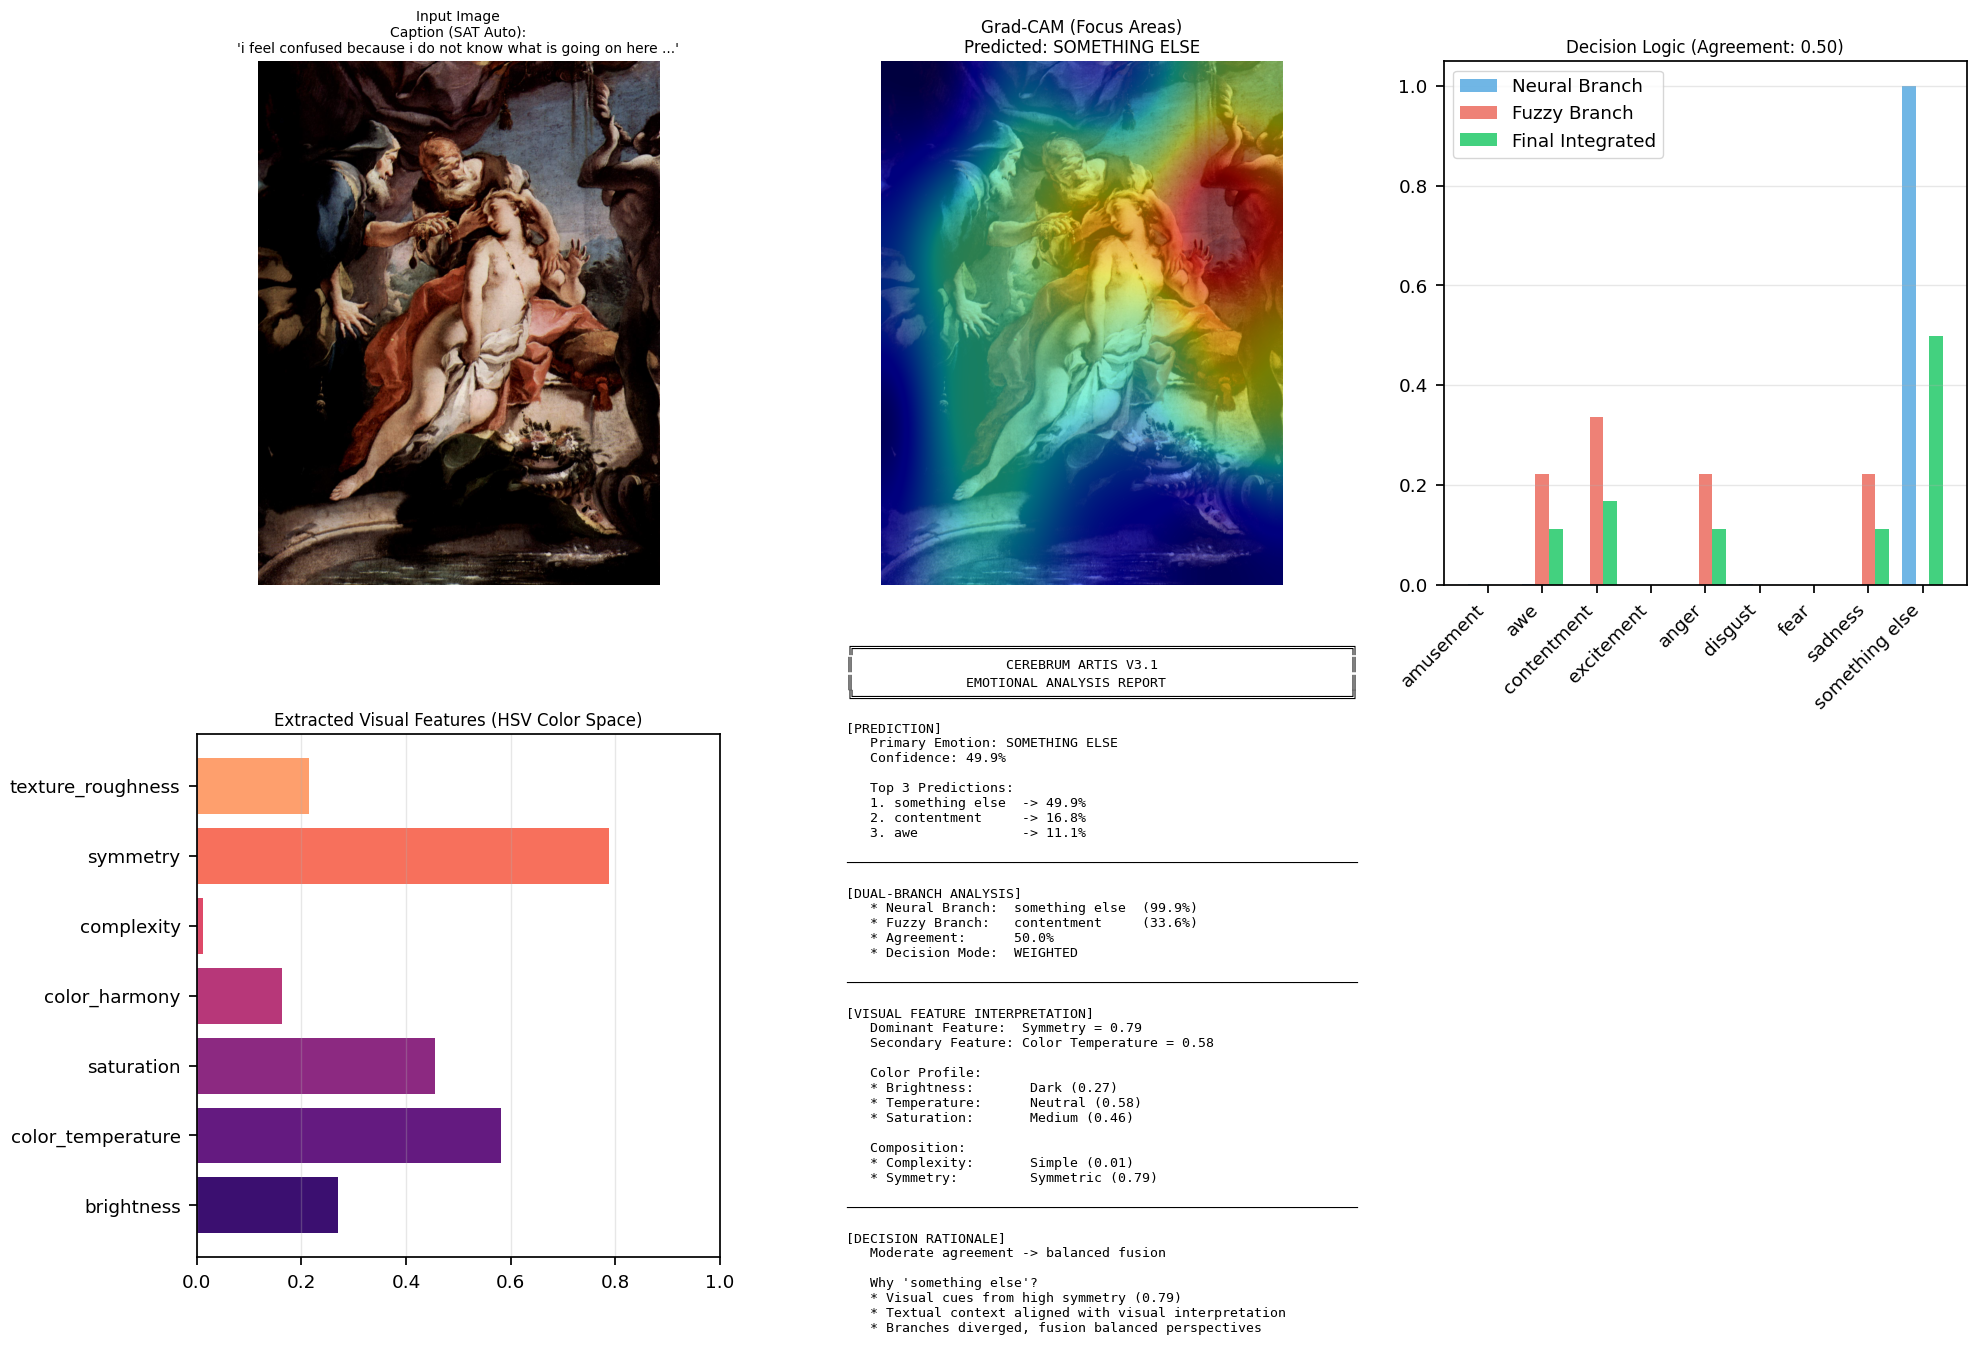


────────────────────────────────────────────────────────────────────────────────
Próxima análise em 2 segundos...

TESTE 2/4: Impressionism - claude-monet_water-lilies-1919
🎨 Analisando: claude-monet_water-lilies-1919.jpg
🤖 Gerando legenda automática (SAT)...

TESTE 2/4: Impressionism - claude-monet_water-lilies-1919
🎨 Analisando: claude-monet_water-lilies-1919.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the water is too blue and the water is not clear'
📝 Legenda: 'the water is too blue and the water is not clear'
🔍 Gerando Grad-CAM para classe: disgust
   🔓 Descongelando ResNet temporariamente para Grad-CAM...
   📊 Grad shape: (2048, 7, 7), Act shape: (2048, 7, 7)
   📊 Grad range: [-0.0002, 0.0001]
   📊 Act range: [0.0000, 8.9647]
   📊 Weights (top 5): [-7.3828883e-06 -5.4255204e-05  9.0187350e-06  1.8656974e-05
  6.5751042e-06]
   📊 Weights range: [-0.0002, 0.0001]
   📊 CAM ANTES ReLU range: [0.0005, 0.0076]
   📊 CAM DEPOIS ReLU range: [0.0005, 0.0076]
   📊 CAM valores úni

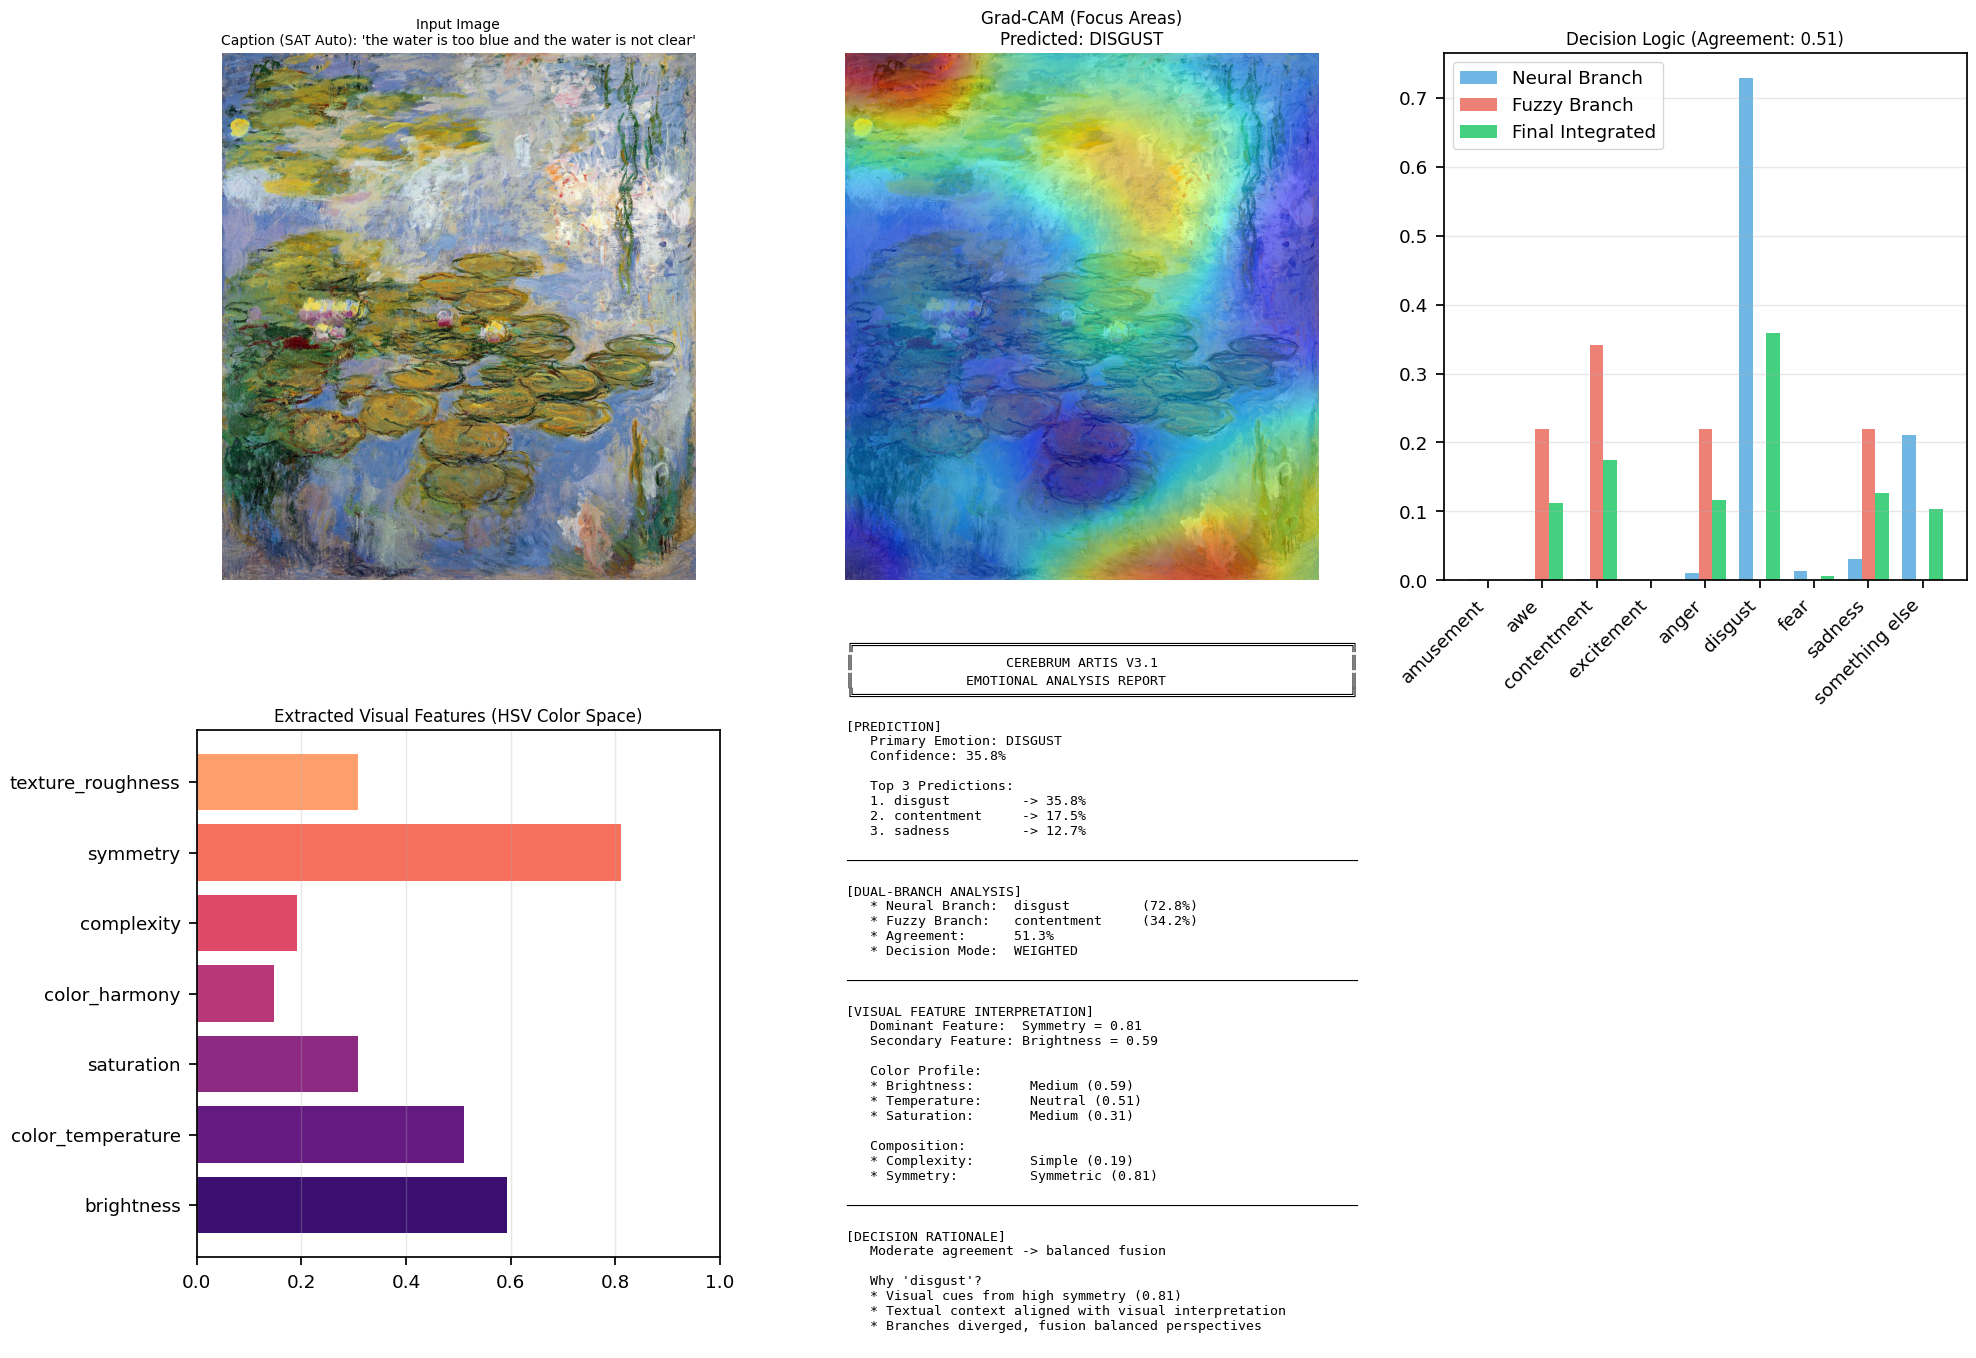


────────────────────────────────────────────────────────────────────────────────
Próxima análise em 2 segundos...

TESTE 3/4: Expressionism - amedeo-modigliani_jean-alexandre-1909
🎨 Analisando: amedeo-modigliani_jean-alexandre-1909.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the man looks bored and like he wants to be elsewhere'

TESTE 3/4: Expressionism - amedeo-modigliani_jean-alexandre-1909
🎨 Analisando: amedeo-modigliani_jean-alexandre-1909.jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the man looks bored and like he wants to be elsewhere'
🔍 Gerando Grad-CAM para classe: sadness
   🔓 Descongelando ResNet temporariamente para Grad-CAM...
   📊 Grad shape: (2048, 7, 7), Act shape: (2048, 7, 7)
   📊 Grad range: [-0.0000, 0.0000]
   📊 Act range: [0.0000, 11.1890]
   📊 Weights (top 5): [ 2.0982215e-07 -3.3576313e-07 -4.8940791e-08  8.4135316e-08
  2.2692140e-07]
   📊 Weights range: [-0.0000, 0.0000]
   ⚠️ Gradientes muito pequenos! Usando Grad-CAM++ (pesos adaptativos)

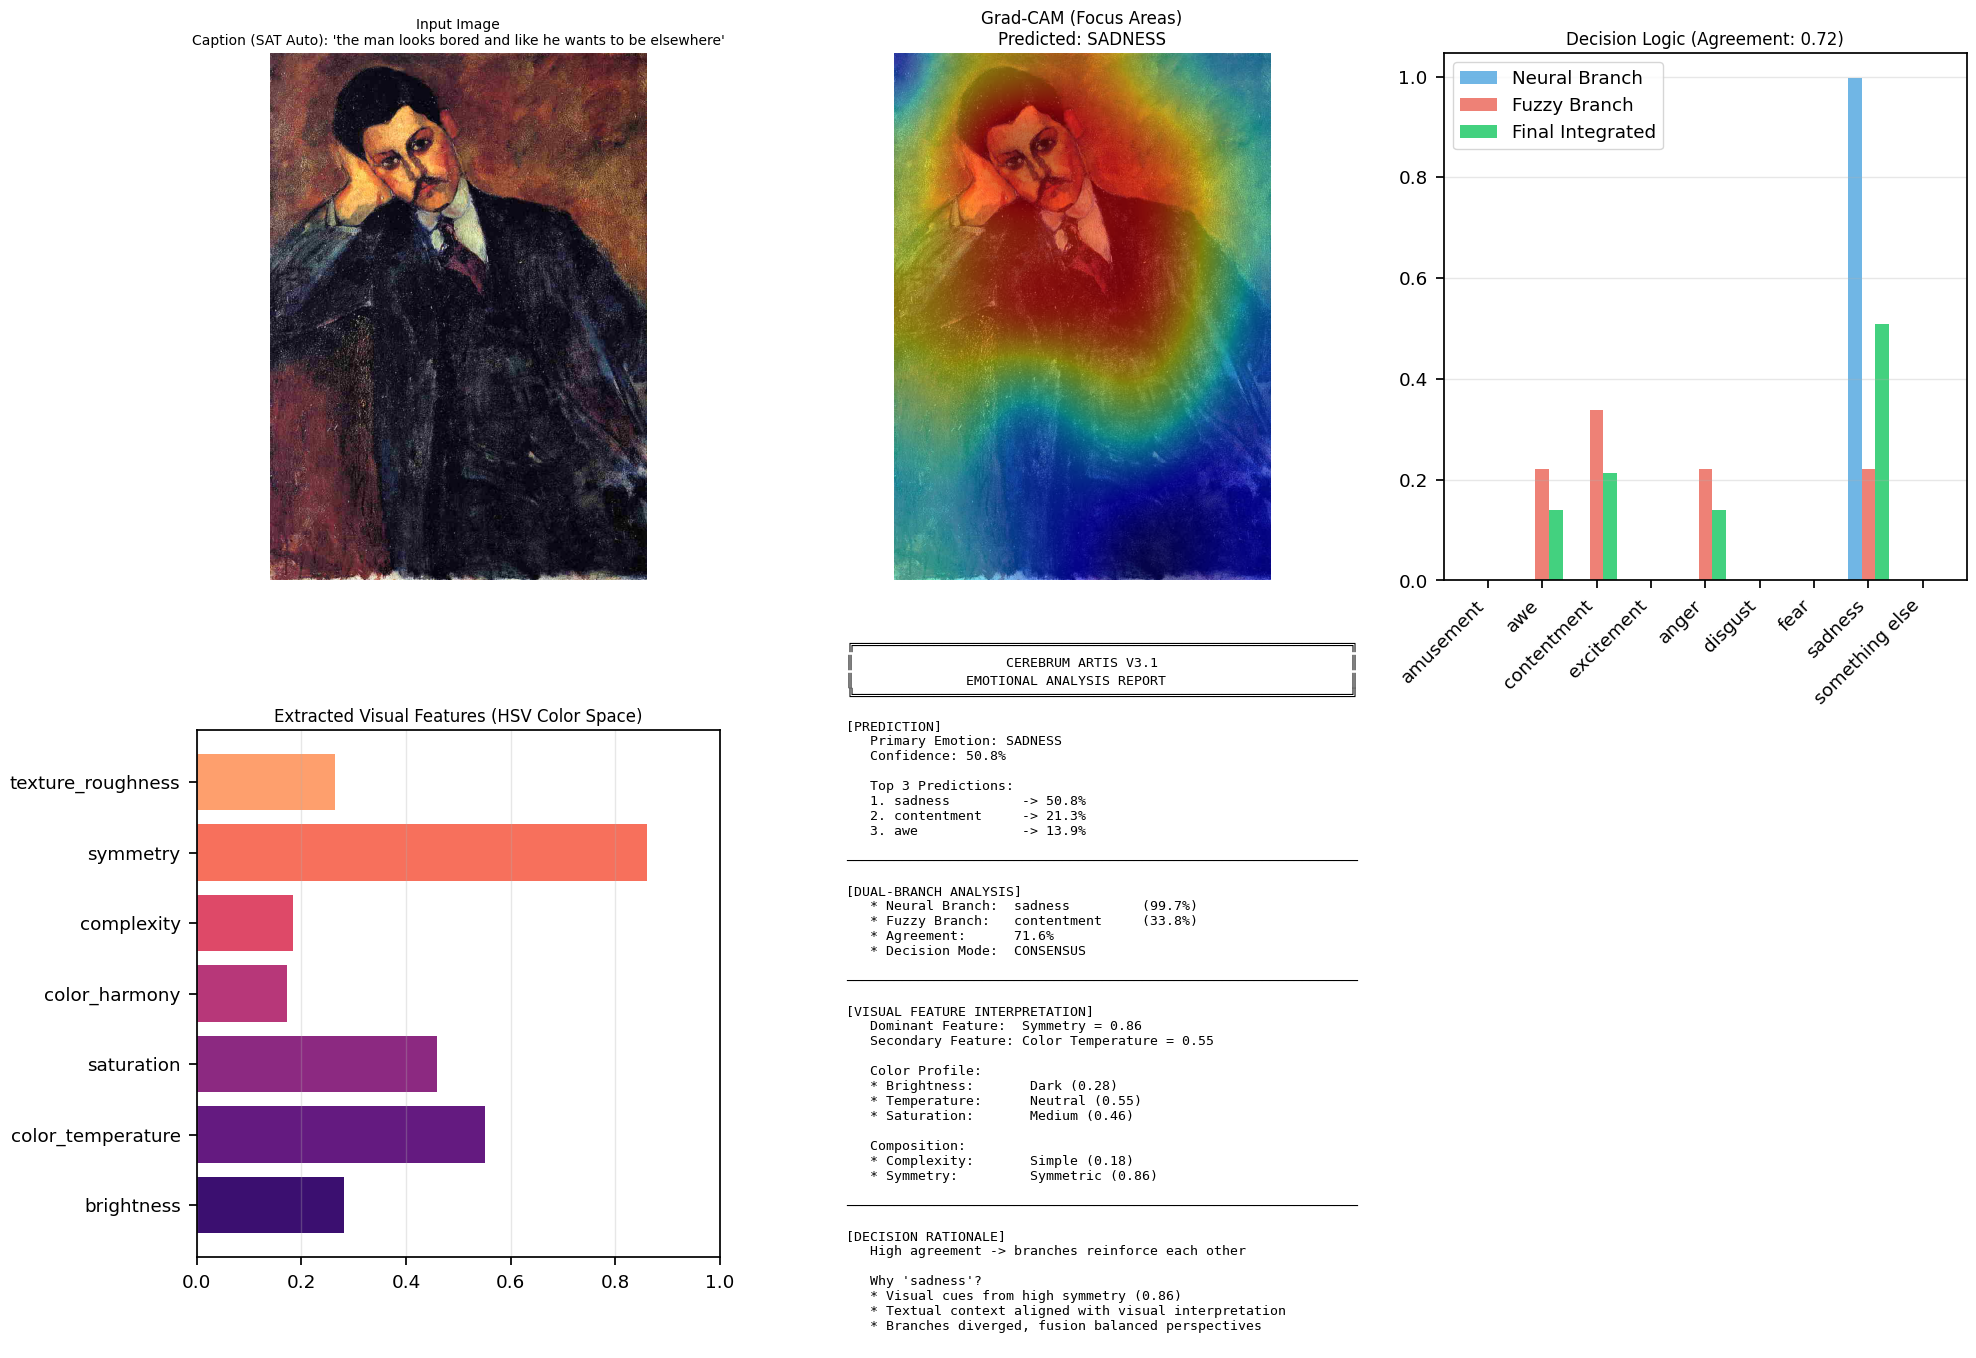


────────────────────────────────────────────────────────────────────────────────
Próxima análise em 2 segundos...

TESTE 4/4: Romanticism - alexander-shilov_natasha-1995(4)
🎨 Analisando: alexander-shilov_natasha-1995(4).jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the girl looks bored and like she wants to be elsewhere'
🔍 Gerando Grad-CAM para classe: sadness
   🔓 Descongelando ResNet temporariamente para Grad-CAM...

TESTE 4/4: Romanticism - alexander-shilov_natasha-1995(4)
🎨 Analisando: alexander-shilov_natasha-1995(4).jpg
🤖 Gerando legenda automática (SAT)...
📝 Legenda: 'the girl looks bored and like she wants to be elsewhere'
🔍 Gerando Grad-CAM para classe: sadness
   🔓 Descongelando ResNet temporariamente para Grad-CAM...
   📊 Grad shape: (2048, 7, 7), Act shape: (2048, 7, 7)
   📊 Grad range: [-0.0000, 0.0000]
   📊 Act range: [0.0000, 9.3306]
   📊 Weights (top 5): [ 4.0494777e-07 -4.8623320e-07 -2.1788306e-07  1.0189767e-07
  2.4406862e-07]
   📊 Weights range: [-0.0000, 

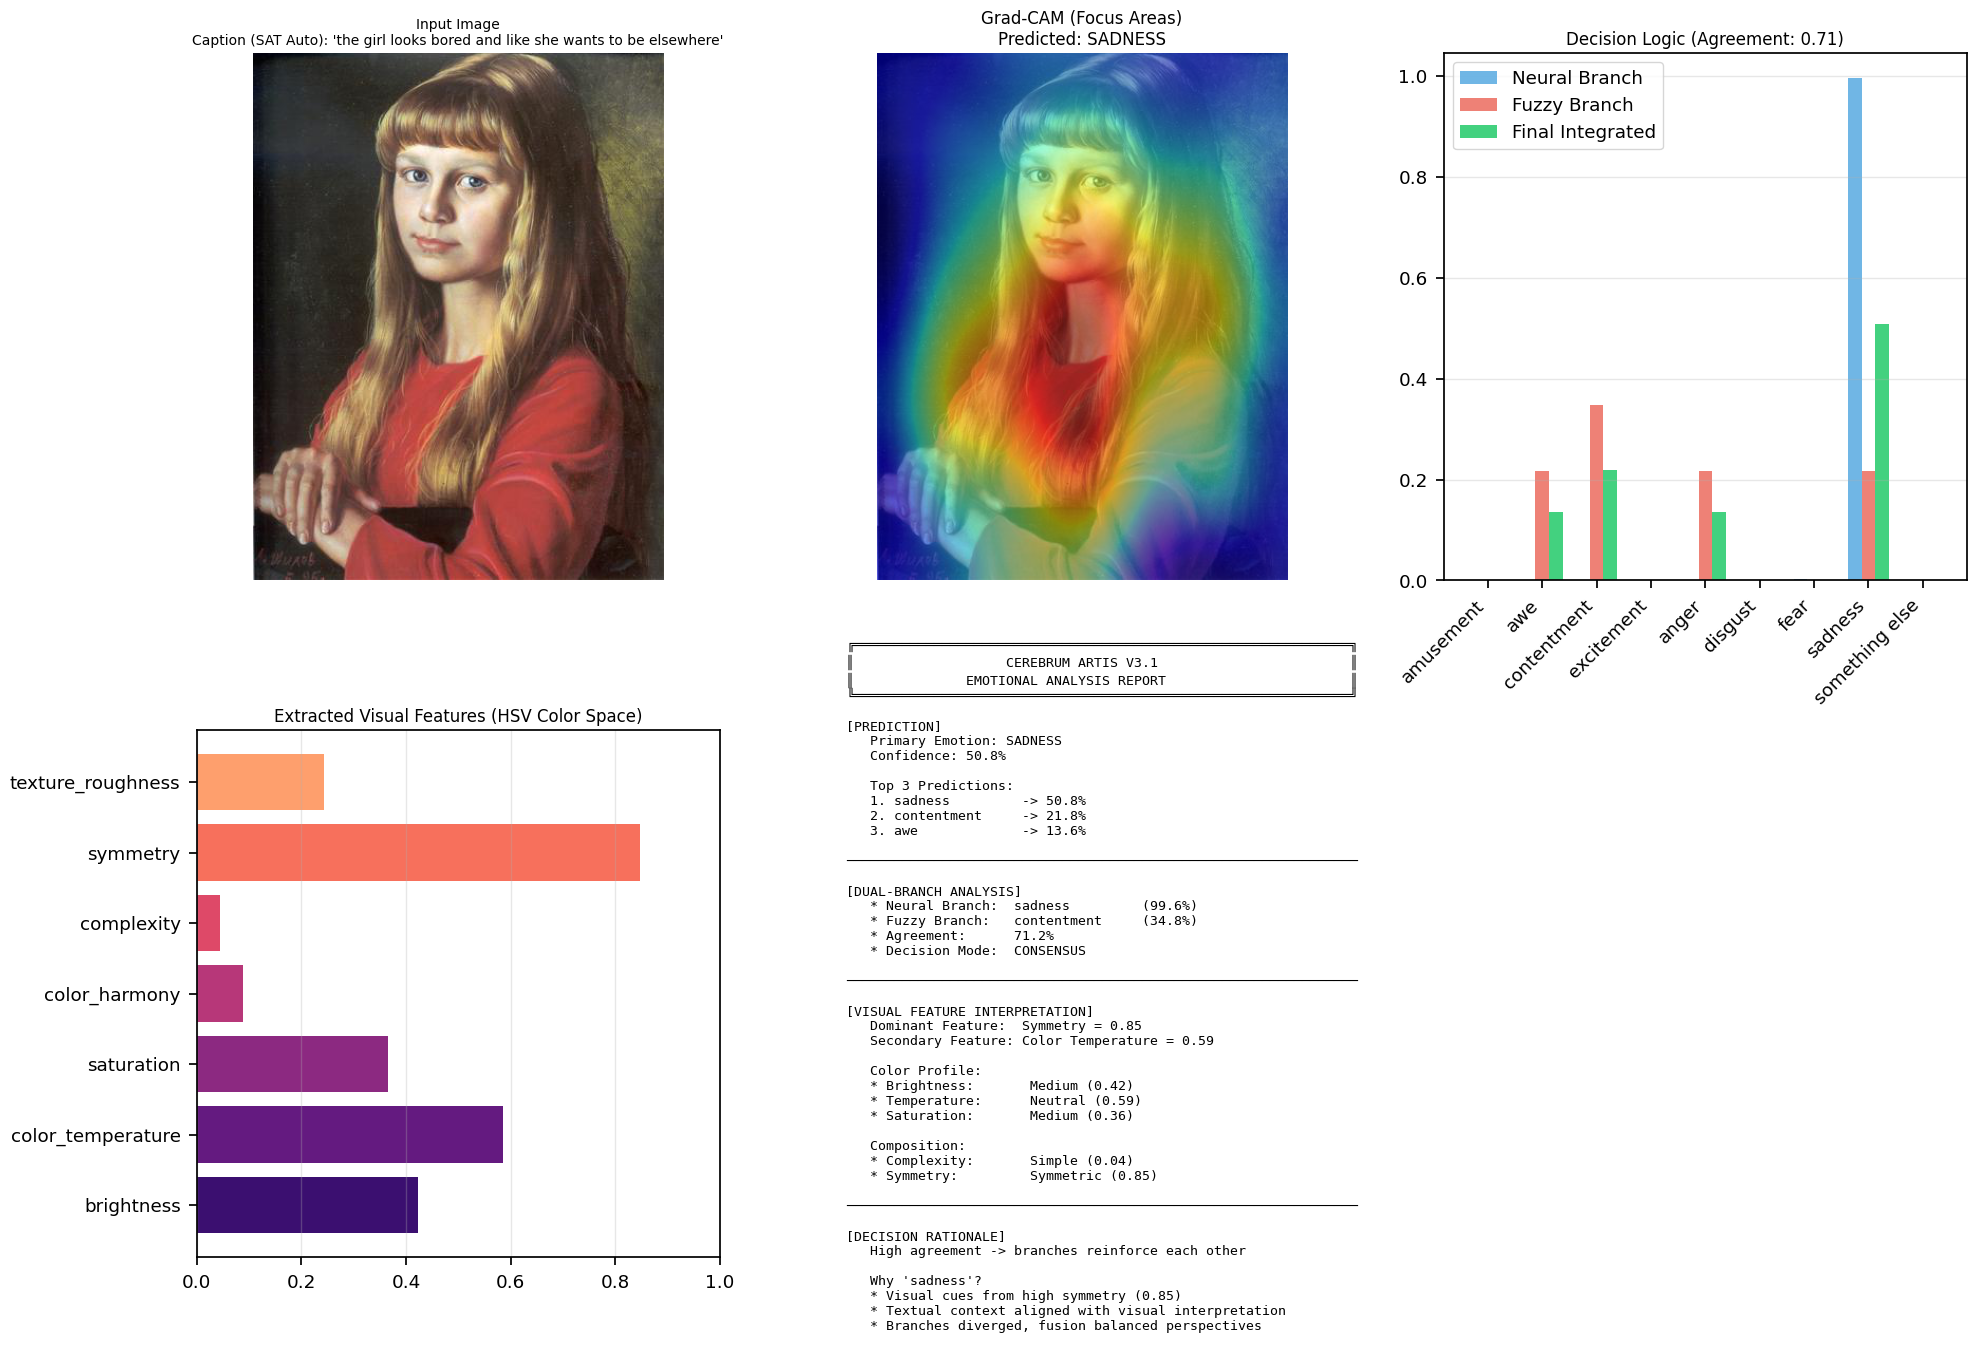


✅ DEMO COMPLETO - Todas as análises concluídas!


In [10]:
# ============================================================================
# 4. EXECUÇÃO DO DEMO - Pinturas Reais do ArtEmis/WikiArt
# ============================================================================

# Diretório com pinturas organizadas por estilo
ARTEMIS_IMAGES_DIR = Path('/data/paloma/data/paintings/wikiart')

# Seleciona pinturas de DIVERSOS estilos para demonstração completa
test_paintings = [
    # Rococo - Dramático
    ARTEMIS_IMAGES_DIR / 'Rococo/giovanni-battista-tiepolo_susanna-and-the-elders-1723.jpg',
    
    # Rococo - Delicado
    ARTEMIS_IMAGES_DIR / 'Baroque/adriaen-brouwer_fumatoreadriaen-brouwer_fumatore.jpg',
    
    # Impressionism - Natureza
    ARTEMIS_IMAGES_DIR / 'Impressionism/claude-monet_water-lilies-1919.jpg',
    
    # Expressionism - Emocional
    ARTEMIS_IMAGES_DIR / 'Expressionism/amedeo-modigliani_jean-alexandre-1909.jpg',
    
    # Romanticism - Épico
    ARTEMIS_IMAGES_DIR / 'Romanticism/alexander-shilov_natasha-1995(4).jpg',
]

# Verifica quais existem
available_paintings = [p for p in test_paintings if p.exists()]

if not available_paintings:
    print("⚠️ Pinturas específicas não encontradas. Selecionando aleatoriamente...")
    # Busca 5 pinturas aleatórias de diferentes estilos
    import random
    styles = [d for d in ARTEMIS_IMAGES_DIR.iterdir() if d.is_dir()][:8]
    available_paintings = []
    for style in styles:
        imgs = list(style.glob('*.jpg'))
        if imgs:
            available_paintings.append(random.choice(imgs))
        if len(available_paintings) >= 5:
            break

print(f"🎨 Testando com {len(available_paintings)} pinturas reais:")
for i, p in enumerate(available_paintings, 1):
    print(f"  {i}. {p.parent.name}/{p.name}")

# ============================================================================
# DEMO LOOP - Analisa todas as pinturas disponíveis
# ============================================================================

for i, painting in enumerate(available_paintings, 1):
    print("\n" + "="*80)
    print(f"TESTE {i}/{len(available_paintings)}: {painting.parent.name} - {painting.stem}")
    print("="*80)
    
    # Usa SAT para gerar legenda automática
    analyze_artwork(painting, caption=None)
    
    # Pequena pausa visual entre análises
    if i < len(available_paintings):
        print("\n" + "─"*80)
        print("Próxima análise em 2 segundos...")
        import time
        time.sleep(2)

print("\n" + "="*80)
print("✅ DEMO COMPLETO - Todas as análises concluídas!")
print("="*80)
